<a href="https://colab.research.google.com/github/Santiago-Rivera-Estrada/Procesamiento_video/blob/main/Procesamiento_video_graficas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instalar OpenCV y MediaPipe
!pip install opencv-python-headless mediapipe
# Importar las bibliotecas necesarias
import cv2 as cv
import mediapipe as mp
import math
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 25.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [3]:
# Clase Detector_Pose
class Detector_Pose():
    def __init__(self, mode=False, smooth=True, confianza_dete=0.5, confianza_segui=0.5):
        # Inicialización de la clase
        self.mode = mode  # Modo de la detección (estática o dinámica)
        self.smooth = smooth  # Suavizado de las landmarks
        self.confianza_dete = confianza_dete  # Umbral de confianza para la detección
        self.confianza_segui = confianza_segui  # Umbral de confianza para el seguimiento
        self.smooth = bool(self.smooth)  # Convertir a booleano
        # Importar las librerías y configurar el modelo de detección de pose
        self.mpPose = mp.solutions.pose
        self.mpDraw = mp.solutions.drawing_utils
        self.pose = self.mpPose.Pose(
            static_image_mode=self.mode,
            model_complexity=0 if self.mode else 1,
            smooth_landmarks=self.smooth,
            min_detection_confidence=self.confianza_dete,
            min_tracking_confidence=self.confianza_segui
        )

    def Obtener_posicion(self, img):
        # Método para obtener las posiciones de los puntos de referencia
        self.lm_List = []  # Lista para almacenar las landmarks relevantes
        coordenadas_xyz = []  # Lista para almacenar las coordenadas XYZ de las landmarks relevantes
        imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convertir imagen a formato RGB
        resul = self.pose.process(imgRGB)  # Procesar la imagen con el modelo de detección de pose
        if resul.pose_landmarks:
            # Si se detectaron landmarks
            for iD, lm in enumerate(resul.pose_landmarks.landmark):
                altura, ancho, canales = img.shape
                if iD == 12 or iD == 14 or iD == 16:
                    # Si la landmark es relevante (hombro, codo o muñeca)
                    cx, cy = int(lm.x * ancho), int(lm.y * altura)  # Calcular las coordenadas en píxeles
                    self.lm_List.append([iD, cx, cy])  # Agregar la landmark a la lista
                    coordenadas_xyz.append([iD, cx, cy, lm.z])  # Agregar coordenadas XYZ a la lista
        return self.lm_List, coordenadas_xyz  # Devolver las listas de landmarks y coordenadas XYZ

    def Obtener_Angulo(self, img, dibujar=True):
        # Método para obtener el ángulo entre tres puntos de referencia relevantes
        lm_List, _ = self.Obtener_posicion(img)  # Obtener la lista de landmarks
        if len(lm_List) >= 3:
            # Si hay al menos tres landmarks detectadas
            x1, y1 = lm_List[0][1:]
            x2, y2 = lm_List[1][1:]
            x3, y3 = lm_List[2][1:]
            x1, y1 = int(x1 * 400 / img.shape[1]), int(y1 * 400 / img.shape[0])
            x2, y2 = int(x2 * 400 / img.shape[1]), int(y2 * 400 / img.shape[0])
            x3, y3 = int(x3 * 400 / img.shape[1]), int(y3 * 400 / img.shape[0])
            # Convertir coordenadas a píxeles (ajustar a un tamaño específico)
            # Calcular el ángulo entre los tres puntos
            angulo = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
            if angulo < 0:
                angulo += 360  # Asegurar que el ángulo esté en el rango de 0 a 360 grados
        return angulo  # Devolver el ángulo calculado


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


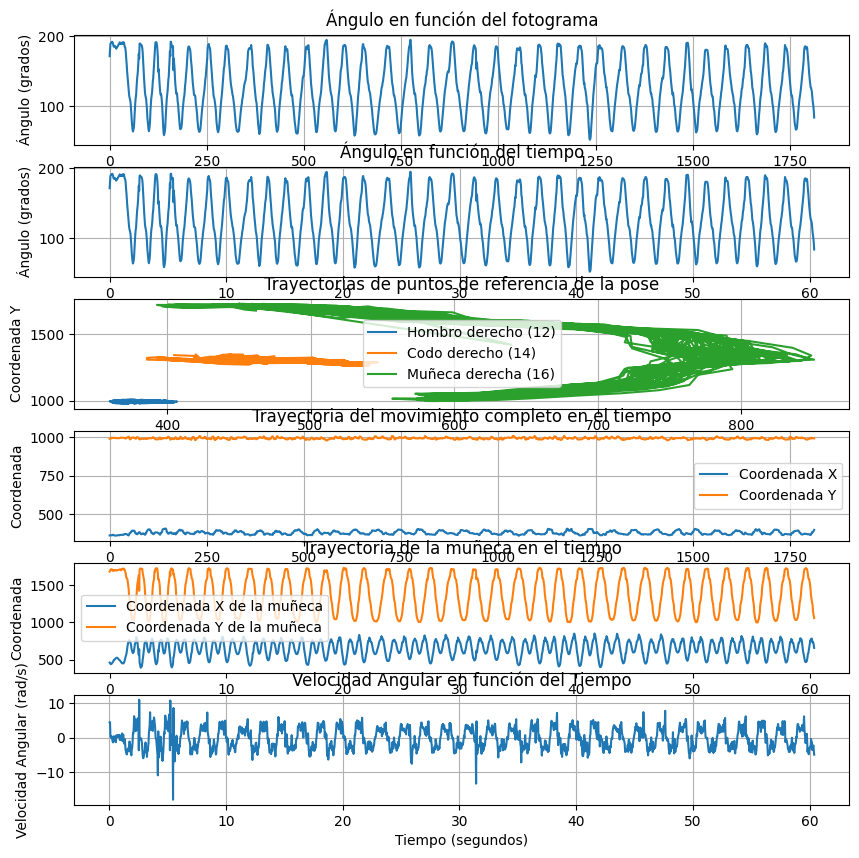

<Figure size 640x480 with 0 Axes>

In [7]:
# Cargar el video
video_path = 'video1.mp4'
cap = cv.VideoCapture(video_path)

# Crear un objeto Detector_Pose
detector = Detector_Pose()

# Listas para almacenar los ángulos calculados y los fotogramas procesados
angulos = []  # Lista para almacenar los ángulos calculados
fotogramas = []  # Lista para almacenar los fotogramas procesados
tiempos = []  # Lista para almacenar los tiempos correspondientes a cada fotograma
frame_count = 0  # Contador de fotogramas
fps = cap.get(cv.CAP_PROP_FPS)  # Obtener el framerate del video
trayectoria_12_x = []  # Lista para almacenar las coordenadas X del hombro derecho
trayectoria_12_y = []  # Lista para almacenar las coordenadas Y del hombro derecho
trayectoria_14_x = []  # Lista para almacenar las coordenadas X del codo derecho
trayectoria_14_y = []  # Lista para almacenar las coordenadas Y del codo derecho
trayectoria_16_x = []  # Lista para almacenar las coordenadas X de la muñeca derecha
trayectoria_16_y = []  # Lista para almacenar las coordenadas Y de la muñeca derecha
coordenadas_x = []  # Lista para almacenar las coordenadas X del marcador relevante
coordenadas_y = []  # Lista para almacenar las coordenadas Y del marcador relevante

# Procesar el video fotograma por fotograma
while cap.isOpened():
    ret, frame = cap.read()  # Leer el siguiente fotograma
    if not ret:
        break  # Si no hay fotogramas restantes, salir del bucle

    # Aplicar la rutina de detección de poses al fotograma actual
    angulo = detector.Obtener_Angulo(frame)  # Calcular el ángulo de la pose
    angulos.append(angulo)  # Agregar el ángulo a la lista de ángulos
    fotogramas.append(frame_count)  # Agregar el número del fotograma a la lista de fotogramas
    tiempo_transcurrido = frame_count / fps  # Calcular el tiempo transcurrido
    tiempos.append(tiempo_transcurrido)  # Agregar el tiempo a la lista de tiempos

    # Incrementar el contador de fotogramas
    frame_count += 1

    # Aplicar la rutina de detección de poses al fotograma actual
    lm_List, _ = detector.Obtener_posicion(frame)  # Obtener las posiciones de los puntos de referencia

    # Almacenar las coordenadas de los puntos de referencia en las listas correspondientes
    for lm in lm_List:
        if lm[0] == 12:
            trayectoria_12_x.append(lm[1])
            trayectoria_12_y.append(lm[2])
        elif lm[0] == 14:
            trayectoria_14_x.append(lm[1])
            trayectoria_14_y.append(lm[2])
        elif lm[0] == 16:
            trayectoria_16_x.append(lm[1])
            trayectoria_16_y.append(lm[2])

    if lm_List:
        x, y = lm_List[0][1], lm_List[0][2]
        coordenadas_x.append(x)
        coordenadas_y.append(y)
angulos_radianes = np.radians(angulos)

# Lista para almacenar la velocidad angular en rad/s
velocidad_angular_radianes = []

# Calcular la velocidad angular en rad/s para cada fotograma
for i in range(1, len(angulos_radianes)):
    delta_theta = angulos_radianes[i] - angulos_radianes[i-1]  # Cambio en el ángulo en radianes
    delta_t = tiempos[i] - tiempos[i-1]  # Cambio en el tiempo
    velocidad_angular_radianes.append(delta_theta / delta_t)  # Calcular la velocidad angular en rad/s y agregar a la lista


cap.release()  # Liberar el objeto VideoCapture
# Graficar los ángulos en función de los fotogramas
plt.figure(figsize=(10,10))  # Tamaño de la figura
plt.subplot(611)
plt.plot(fotogramas, angulos)
plt.title('Ángulo en función del fotograma')
plt.xlabel('Fotograma')
plt.ylabel('Ángulo (grados)')
plt.grid(True)

plt.subplot(612)
plt.plot(tiempos, angulos)
plt.title('Ángulo en función del tiempo')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Ángulo (grados)')
plt.grid(True)

plt.subplot(613)
plt.plot(trayectoria_12_x, trayectoria_12_y, label='Hombro derecho (12)')
plt.plot(trayectoria_14_x, trayectoria_14_y, label='Codo derecho (14)')
plt.plot(trayectoria_16_x, trayectoria_16_y, label='Muñeca derecha (16)')
plt.title('Trayectorias de puntos de referencia de la pose')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.legend()
plt.grid(True)

plt.subplot(614)
plt.plot(fotogramas, coordenadas_x, label='Coordenada X')
plt.plot(fotogramas, coordenadas_y, label='Coordenada Y')
plt.title('Trayectoria del movimiento completo en el tiempo')
plt.xlabel('Número de fotograma')
plt.ylabel('Coordenada')
plt.legend()
plt.grid(True)
plt.subplot(615)
plt.plot(tiempos, trayectoria_16_x, label='Coordenada X de la muñeca')
plt.plot(tiempos, trayectoria_16_y, label='Coordenada Y de la muñeca')
plt.title('Trayectoria de la muñeca en el tiempo')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Coordenada')
plt.legend()
plt.subplot(616)
plt.plot(tiempos[1:], velocidad_angular_radianes)  # Excluyendo el primer valor de tiempos para que tengan la misma longitud
plt.title('Velocidad Angular en función del Tiempo')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Velocidad Angular (rad/s)')
plt.grid(True)
plt.show()
plt.tight_layout()  # Ajustar el diseño de la figura
plt.show()  # Mostrar la figura



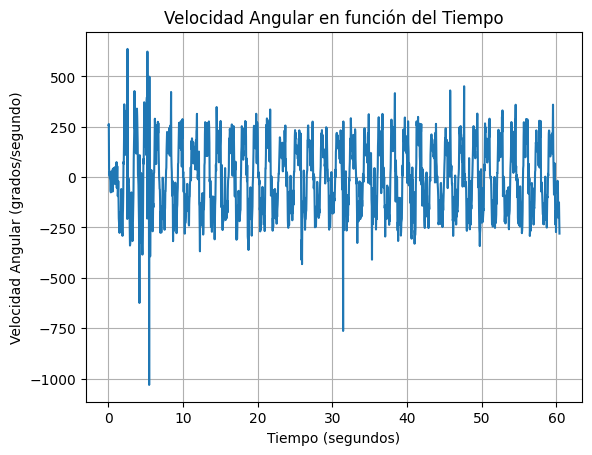

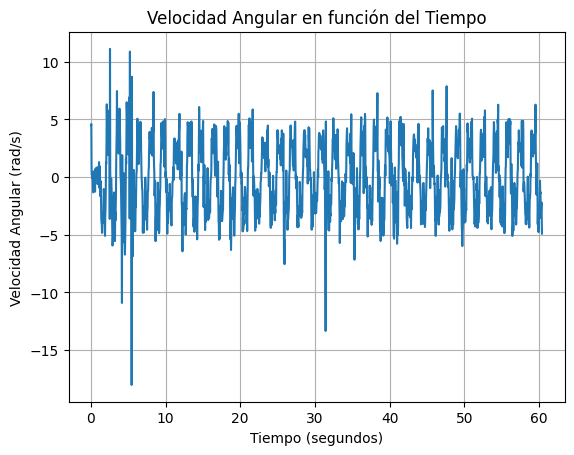